In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]="1"

#load mode
model_dir ='/media/tohn/HDD2/car-dataset-2025/model_h5_degree/models/B5R3_degree_200epoch.h5' #แก้
model = load_model(model_dir)
height = width = model.input_shape[1]

In [2]:
# training CSV file
dataframe = pd.read_csv (r'/home/yupaporn/codes/Train_Part-Degree/train_class_degree.csv')
valframe = pd.read_csv (r'/home/yupaporn/codes/Train_Part-Degree/val_class_degree.csv')
print(dataframe.shape)
print(valframe.shape)

# training images path 
DATA_PATH = "/media/tohn/HDD2/car-dataset-2025"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'Train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'Valid')
print(validation_dir)

(16000, 8)
(3200, 8)
/media/tohn/HDD2/car-dataset-2025/Train
/media/tohn/HDD2/car-dataset-2025/Valid


In [3]:
batch_size = 1
epochs = 10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'img_path',
        y_col = 'class_degree',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'img_path',
        y_col = 'class_degree',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')
#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 16000 validated image filenames belonging to 4 classes.
Found 3200 validated image filenames belonging to 4 classes.
{0: 'Base', 1: 'Minor', 2: 'Moderate', 3: 'Severe'}


In [4]:
dataframe = pd.read_csv (r'/home/yupaporn/codes/Train_Part-Degree/output.csv')
test = dataframe[dataframe['split'] == 'Test(real)']
test = test
print(test.shape)

(300, 7)


In [5]:
set(dataframe['split'])

{'Test', 'Test(real)', 'Train', 'Train(fine-tune)', 'Valid'}

In [6]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

# Predict
pred_list = list()
prob_list = list()
img_path=test['img_path'].tolist()
for i in range(0,len(img_path)):
    print(f'on processing {i+1}/{len(img_path)-(i+1)}')
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

test['category'] = pred_list
test['Prob'] = prob_list

on processing 1/299
on processing 2/298
on processing 3/297
on processing 4/296
on processing 5/295
on processing 6/294
on processing 7/293
on processing 8/292
on processing 9/291
on processing 10/290
on processing 11/289
on processing 12/288
on processing 13/287
on processing 14/286
on processing 15/285
on processing 16/284
on processing 17/283
on processing 18/282
on processing 19/281
on processing 20/280
on processing 21/279
on processing 22/278
on processing 23/277
on processing 24/276
on processing 25/275
on processing 26/274
on processing 27/273
on processing 28/272
on processing 29/271
on processing 30/270
on processing 31/269
on processing 32/268
on processing 33/267
on processing 34/266
on processing 35/265
on processing 36/264
on processing 37/263
on processing 38/262
on processing 39/261
on processing 40/260
on processing 41/259
on processing 42/258
on processing 43/257
on processing 44/256
on processing 45/255
on processing 46/254
on processing 47/253
on processing 48/252
o

/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
data_train = test
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['class_degree'])
print('Actual : ',len(classe))
print(classe)

Predicted :  4
{'Moderate', 'Severe', 'Minor', 'Base'}
Actual :  4
{'Moderate', 'Severe', 'Minor', 'Base'}


In [12]:
data_train.to_csv('./result_degree_real300.csv')

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['class_degree'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performanceimport numpy as np

classifier accuracy = 94.0%
              precision    recall  f1-score   support

        Base       0.99      0.99      0.99        75
       Minor       0.97      0.92      0.95        75
    Moderate       0.90      0.95      0.92        75
      Severe       0.91      0.91      0.91        75

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



Text(0.5, 21.5, 'Predicted label')

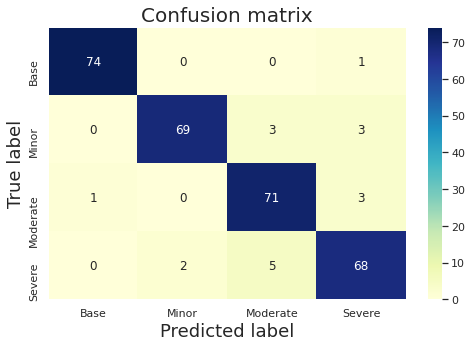

In [9]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [10]:
11/1.5

7.333333333333333

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

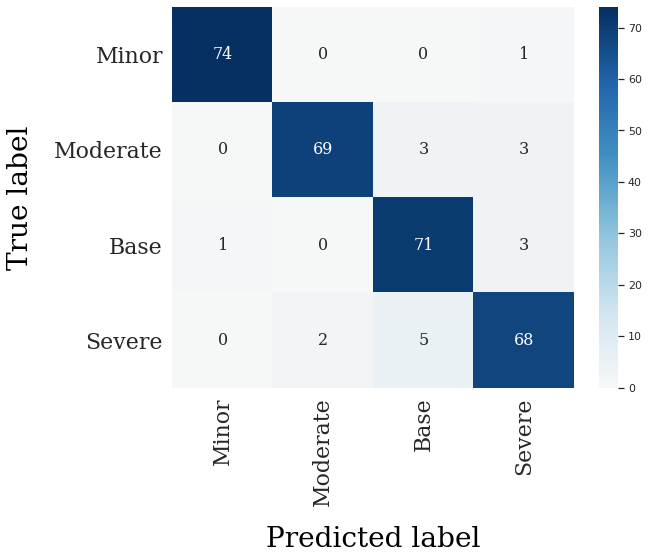

In [11]:
classes = np.array(['Minor', 'Moderate', 'Base', 'Severe'])
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix_normalized(cm,group):
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal'}
    sns.set()

    fig, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu", center=0, xticklabels=classes, yticklabels=classes, annot_kws={'family': 'serif', "size": 16}) #Blues,Oranges,Reds,YlGnBu
    ax.set(xticklabels=classes, yticklabels=classes)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    ax.set_ylabel('True label',fontsize=28, fontdict=font, labelpad=20)
    ax.set_xlabel('Predicted label',fontsize=28, fontdict=font, labelpad=20)
   
    hfont = {'fontname':'serif'}
    plt.yticks(fontsize=22, **hfont)
    plt.xticks(fontsize=22, **hfont)


    return ax


# act = df_original['Sub_class_New'].array
# pred_paper = df_original['category'].array
# pred_unlearn = df_unlearn['category'].array

act = data_train['class_degree'].array
pred = data_train['category'].array

# Compute confusion matrices
cm_base = confusion_matrix(act, pred)
# cm_unlearn = confusion_matrix(act, pred_unlearn)

# Compute the difference matrix
cm_diff = cm_base

cm = cm_diff 
group = 'with all groups'
confusion_matrix_normalized(cm,group)